In [1]:
! pip install git+https://github.com/huggingface/transformers
! git clone https://github.com/Yushi-Hu/tifa

In [1]:
import os
import numpy as np
import pandas as pd
import requests
from PIL import Image
import torch
from transformers import ViltProcessor, ViltForQuestionAnswering
import requests
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm

In [2]:
# Address of the generated images
base_address = "./two_entity_images"

seed = 42

prompts = [prompt for prompt in os.listdir(base_address) if prompt.split(".")[-1] != "csv"]
print(len(prompts))

2485


In [ ]:
from tifa.tifascore.vqa_models import BLIP2, VQAModel

tifa_model = VQAModel("mplug-large")

In [3]:
def calculate_vqa_score(vqa_model, prompts, seed):
    vqa_scores = []
    for prompt in tqdm(prompts):
        entity_1, entity_2 = prompt.split(" ")[1], prompt.split(" ")[4]
        question_1 = f"Is there any {entity_1} in the picture?"
        question_2 = f"Is there any {entity_2} in the picture?"
        image_address = f"{base_address}/{prompt}/{seed}/image.png"
        score_1 = 1 if (vqa_model.multiple_choice_vqa(image_address, question_1, choices=['yes', 'no']))['multiple_choice_answer']=="yes" else 0
        score_2 = 1 if (vqa_model.multiple_choice_vqa(image_address, question_2, choices=['yes', 'no']))['multiple_choice_answer']=="yes" else 0
        vqa_scores.append((score_1 + score_2) / 2)
    return vqa_scores

In [6]:
vqa_scores = calculate_vqa_score(tifa_model, prompts, seed)

pd.DataFrame(data={"prompt": prompts, "vqa_score": vqa_scores}).to_csv(f"{base_address}/tifa_scores.csv", index=False)

  0%|          | 0/2485 [00:00<?, ?it/s]c:\Users\user01\anaconda3\envs\attend_and_excite_2\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
c:\Users\user01\anaconda3\envs\attend_and_excite_2\lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 2485/2485 [42:00<00:00,  1.01s/it]


In [7]:
pd.DataFrame(data={"prompt": prompts, "vqa_score": vqa_scores}).to_csv(f"{base_address}/tifa_scores.csv", index=False)

In [3]:
vqa_scores = pd.read_csv(f"{base_address}/tifa_scores.csv")["vqa_score"].tolist()

print(len(vqa_scores))

2485


In [4]:
validate_entities = pd.read_csv("../entities/validation_entities.csv")["entity"].tolist()
print(len(validate_entities))

validation_prompts, validation_vqa_scores = [], []

for index, prompt in enumerate(prompts):
    entity_1, entity_2 = prompt.split(" ")[1], prompt.split(" ")[4]
    if entity_1 in validate_entities and entity_2 in validate_entities:
        validation_prompts.append(prompt)
        validation_vqa_scores.append(vqa_scores[index])

print(len(validation_prompts), len(validation_vqa_scores))

prompts, vqa_scores = validation_prompts, validation_vqa_scores

print(len(prompts), len(vqa_scores))

20
190 190
190 190


In [5]:
analysis_df = pd.read_csv(f"{base_address}/{prompts[0]}/{seed}/analysis.csv")
steps = analysis_df["step"].values.tolist()
analysis_df.drop(columns=["step"], inplace=True)
metrics = analysis_df.columns.values.tolist()

analysis_dict = {metric: {step: [] for step in steps} for metric in pd.read_csv(f"{base_address}/{prompts[0]}/{seed}/analysis.csv").columns.values.tolist()}

for i, prompt in enumerate(prompts):
    prompt_analysis_df = pd.read_csv(f"{base_address}/{prompt}/{seed}/analysis.csv")
    for metric in metrics:
        for step in steps:
            analysis_dict[metric][step].append(prompt_analysis_df[metric].values.tolist()[step])

In [6]:
analysis_dict["com_distance"] = {step: [] for step in steps}
for step in steps:
    for index in range(len(prompts)):
        analysis_dict["com_distance"][step].append(np.sqrt(np.power(analysis_dict["com_1_x"][step][index] - analysis_dict["com_2_x"][step][index], 2) + 
                                                   np.power(analysis_dict["com_1_y"][step][index] - analysis_dict["com_2_y"][step][index], 2)))

In [7]:
analysis_dict["mean_kl"] = {step: [] for step in steps}
for step in steps:
    for index in range(len(prompts)):
        analysis_dict["mean_kl"][step].append((analysis_dict["kl_1_2"][step][index] + analysis_dict["kl_2_1"][step][index])/2)

In [8]:
analysis_dict["mean_tv"] = {step: [] for step in steps}
for step in steps:
    for index in range(len(prompts)):
        analysis_dict["mean_tv"][step].append((analysis_dict["tv_1"][step][index] + analysis_dict["tv_2"][step][index])/2)

In [9]:
analysis_dict["mean_variance"] = {step: [] for step in steps}
for step in steps:
    for index in range(len(prompts)):
        analysis_dict["mean_variance"][step].append((analysis_dict["variance_1"][step][index] + analysis_dict["variance_1"][step][index])/2)

In [10]:
analysis_dict["min_intensity"] = {step: [] for step in steps}
for step in steps:
    for index in range(len(prompts)):
        analysis_dict["min_intensity"][step].append(min(analysis_dict["intensity_1"][step][index], analysis_dict["intensity_2"][step][index]))

In [13]:
font = {"fontname": "Times New Roman"}

def generate_bar_plot(metric_values, vqa_scores, step, n_bins, n_round, rotation, title, xlabel, ylabel, width, fig_index, fig_base_address):
    bin_width = round((max(metric_values) - min(metric_values)) / n_bins, n_round)
    bins = {(round(start, n_round), round(start+bin_width, n_round)): 0 
            for start in np.linspace(min(metric_values), max(metric_values) - bin_width, n_bins)}
    bins_counter = {bin: 0 for bin in bins.keys()}

    for index, metric_value in enumerate(metric_values): 
        for (lb, up) in bins.keys():
            if lb < metric_value <= up:
                bins[(lb, up)] += vqa_scores[index]
                bins_counter[(lb, up)] += 1
    
    for key in bins.keys():
        if bins_counter[key] > 0:
            bins[key] /= bins_counter[key]
    
    must_remove = []
    for key, value in bins.items():
        if value == 0:
            must_remove.append(key)
    for remove_key in must_remove:
        bins.pop(remove_key)

    last_up = None
    changes = dict()
    for key in bins.keys():
        old_lb, up = key
        if last_up is not None and old_lb < last_up:
            changes[(last_up, up)] = (old_lb, up)
        last_up = up
    for key, value in changes.items():
        bins[key] = bins.pop(value)
        
    sorted_keys = sorted(list(bins.keys()))
    bins = {key: bins[key] for key in sorted_keys}
    

    plt.bar([f"{lb}-{up}" for (lb, up) in bins.keys()], 
            list(bins.values()), 
            color='#7D87F9',
            zorder=3,
            alpha=1,
            width=[count/sum(bins_counter.values()) for count in bins_counter.values()] if width else 0.5,)
    
    plt.plot([f"{lb}-{up}" for (lb, up) in bins.keys()], 
             list(bins.values()),
             "*-",
             color="#7D87F9")
    
    plt.xticks(rotation=rotation, **font)
    plt.yticks(**font)
    fontsize = 30
    # plt.ylabel(ylabel, fontweight="bold", fontsize=fontsize, labelpad=7, **font)
    # plt.xlabel(xlabel, fontweight="bold", fontsize=fontsize, labelpad=7, **font)
    # plt.title(f"({fig_index})",fontweight="bold", fontsize=fontsize, **font)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    # plt.gca().set_facecolor("lightgray")
    
    # plt.title(title)
    # plt.grid(axis='y', zorder=0)
    # plt.show()
    plt.savefig(f"{fig_base_address}/{xlabel}.pdf", bbox_inches='tight')
    plt.savefig(f"{fig_base_address}/{xlabel}.png", bbox_inches='tight')
    plt.close()

In [ ]:
plot_info_list = [{"metric": "overlap_ps", "coef": 1, "step": 50, "n_bins": 4, "n_rounds": 2, "xlabel": "PS Overlap", "fig_index": "A"},
                  {"metric": "com_distance", "coef": 1, "step": 50, "n_bins": 4, "n_rounds": 2, "xlabel": "CoM Distance", "fig_index": "C"},
                  {"metric": "mean_kl", "coef": 1, "step": 50, "n_bins": 4, "n_rounds": 2, "xlabel": "KL Divergence", "fig_index": "D"},
                  {"metric": "cc", "coef": 100, "step": 50, "n_bins": 4, "n_rounds": 2, "xlabel": "Clustering Compactness", "fig_index": "E"},
                  {"metric": "min_intensity", "coef": 100, "step": 50, "n_bins": 4, "n_rounds": 2, "xlabel": "Min Intensity", "fig_index": "F"},
                  {"metric": "mean_variance", "coef": 1, "step": 50, "n_bins": 4, "n_rounds": 1, "xlabel": "Variance", "fig_index": "G"}]

fig_base_address = "figures"

for plot_info in plot_info_list:
    print(plot_info["metric"])
    generate_bar_plot(metric_values=np.array(analysis_dict[plot_info["metric"]][plot_info["step"]]) * plot_info["coef"], 
                      vqa_scores=vqa_scores,
                      step=plot_info["step"],
                      n_bins=plot_info["n_bins"],
                      n_round=plot_info["n_rounds"],
                      rotation=0,
                      title=f"t={plot_info['step']}",
                      xlabel=plot_info["xlabel"],
                      ylabel="VQA Score",
                      width=False,
                      fig_index=plot_info["fig_index"],
                      fig_base_address=fig_base_address)

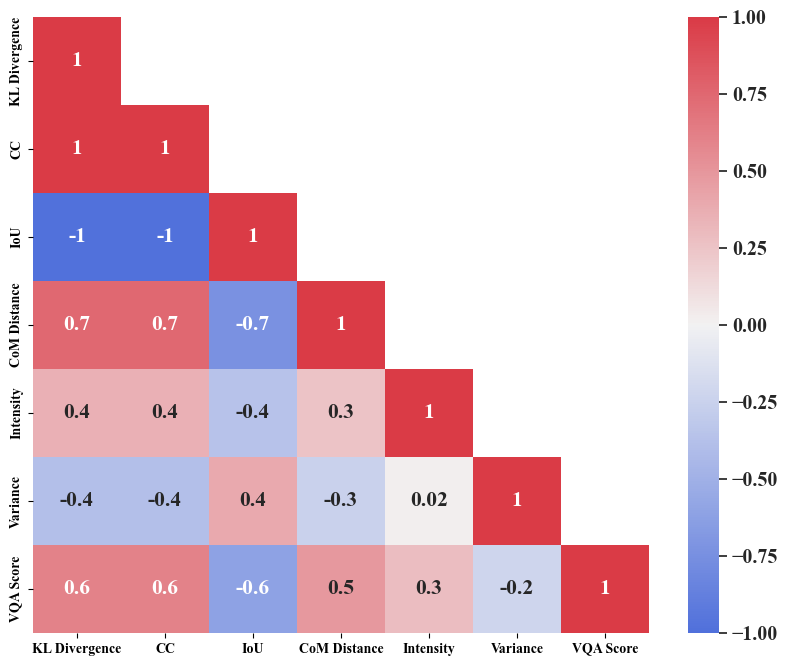

In [12]:
step = 50
df = pd.DataFrame(data={"KL Divergence": analysis_dict["mean_kl"][step],
                        "CC": analysis_dict["mean_kl"][step],
                        "IoU": analysis_dict["overlap_ps"][step],
                        "CoM Distance": analysis_dict["com_distance"][step],
                        "Intensity": analysis_dict["min_intensity"][step],
                        "Variance": analysis_dict["mean_variance"][step],
                        "VQA Score": vqa_scores})

fig_base_address = "figures"

corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
f, ax = plt.subplots(figsize=(10, 8))

sns.set(font_scale=1.3, font="Times New Roman")
sns.heatmap(corr,
    cmap=sns.diverging_palette(260, 10, as_cmap=True),
    vmin=-1, vmax=1,
    square=True, ax=ax, annot=True, fmt='.1g',
    mask=mask
    )
    # annot_kws={"fontsize":30})
plt.savefig(f"{fig_base_address}/analysis_corr_matrix.pdf", bbox_inches='tight')
plt.savefig(f"{fig_base_address}/analysis_corr_matrix.png", bbox_inches='tight')